# Which Movies Make a Profit?
## CPSC 322 Final Project by Kat Sotelo Jimenez and Ciara Patterson

# Introduction
In this data science project, we investigated the possibility of predicting a film's financial success from features like it's director, writer, IMDb rating, etc. We wanted to understand if some types of films were more financially successful than others. While this analysis is preliminary, one day similar analysis could be used to help studios decide whether they want to invest in a film.

Our EDA demonstrated that movies that typically have a higher IMDb rating also have higher profits, and we believe that is because you have to buy a ticket or to pay to rent the movie before you can review it. We also saw that comedy and action movies had made more of a profit and that G, PG, and PG-13 movies tend to make more money than movies with more mature ratings.

The classifications that we implemented are Decision Tree Classifier, Naive Bayes Classifier, Random Forest Classifier, and the K Nearest Neighbors Classifier. After initial testing we decided to deploy our KNN classifier because it had the most even class recognition. 

In [22]:
# some useful mysklearn package import statements and reloads
import importlib

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils
from mysklearn.myutils import MinMaxScale

import mysklearn.myutils_tabulate_dependency
importlib.reload(mysklearn.myutils_tabulate_dependency)
import mysklearn.myutils_tabulate_dependency as myutils_tabulate

# uncomment once you paste your mypytable.py into mysklearn package
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 


import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MySimpleLinearRegressor, MyNaiveBayesClassifier, MyDecisionTreeClassifier, ZeroRClassifier, RandomClassifier, MyRandomForestClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myeval
import os

import plot_utils
importlib.reload(plot_utils)
import plot_utils as pu

import math
from collections import Counter
from statistics import median


# Data Analysis

First, we'll load the dataset. We retrieved this dataset from Kaggle.com. It was posted as a single CSV file. This dataset contains information about 6820 movies, 220 movies each year from the year 1986-2016. This data was scraped from IMDb.

In [2]:
movies_fname = os.path.join('input_data', 'movies.csv')
movies_table = MyPyTable().load_from_file(movies_fname, encode = 'cp1252')

## Attributes 

The attributes on the dataset are:
* Budget: The budget the movie had. For movies that don’t have any it is 0.
* Company: The production company
* Country: The movies country of origin
* Director: The director of the movie
* Genre: The main genre of the movie:
* Gross: The revenue of the the movie
* Name: The name of the movie
* Rating: The rating of the movie (R, PG, PG-13, etc.)
* Released: The release date(yyyy-mm-dd)
* Runtime: The duration of the movie.
* Score: What IMDb user rating it has.
* Votes: The number of user votes.
* Star: The main actor and actress
* Writer: The writer of the movie
* Year: The year of release. 

The attributes that we will mainly use are budget, director, genre, gross, name, rating, score, votes, star and writer. Many of our classifiers perform best with categorical attributes. We will both analyze the distribution of some of these features and use the inter-quartile range to discretize the features into categorical attributes.

## Discretizing the votes features


In [3]:
# Votes 
votes_col = movies_table.get_column("votes")
unique_votes = myutils.compute_unique_list(votes_col)
# print("Unique Votes:", unique_votes)
max_vote = max(unique_votes)
min_vote = min(unique_votes)
print("MAX:" , max_vote)
print("MIN: ", min_vote)
median_vote = median(unique_votes)
print("MEDIAN:", median_vote)
new_list = [min_vote, median_vote]
new_median = median(new_list)
print("min to median",new_median)
other_list = [median_vote, max_vote]
other_median = median(other_list)
print("median to max: ", other_median)
new_list_ratings = [min_vote, new_median, median_vote, other_median, max_vote]
print(new_list_ratings)

MAX: 1861666.0
MIN:  27.0
MEDIAN: 28054.0
min to median 14040.5
median to max:  944860.0
[27.0, 14040.5, 28054.0, 944860.0, 1861666.0]


In [4]:
# Votes 
votes_col = movies_table.get_column("votes")
unique_votes = myutils.compute_unique_list(votes_col)
# print("Unique Votes:", unique_votes)
max_vote = max(unique_votes)
min_vote = min(unique_votes)
print("MAX:" , max_vote)
print("MIN: ", min_vote)
median_vote = median(unique_votes)
print("MEDIAN:", median_vote)
new_list = [min_vote, median_vote]
new_median = median(new_list)
print("min to median",new_median)
other_list = [median_vote, max_vote]
other_median = median(other_list)
print("median to max: ", other_median)
new_list_ratings = [min_vote, new_median, median_vote, other_median, max_vote]
print(new_list_ratings)

MAX: 1861666.0
MIN:  27.0
MEDIAN: 28054.0
min to median 14040.5
median to max:  944860.0
[27.0, 14040.5, 28054.0, 944860.0, 1861666.0]


In [5]:
votes_data = myutils.compute_votes(votes_col)

## add a column with the discretized votes
movies_table.add_column(votes_data, 'discretized_vote')

### Discretize the score column

In [6]:
scores_col = movies_table.get_column("score")
unique_scores = myutils.compute_unique_list(scores_col)
# print("Unique scores:", unique_scores)
max_score = max(unique_scores)
min_score = min(unique_scores)
print("MAX:" , max_score)
print("MIN: ", min_score)
median_score = median(unique_scores)
print("MEDIAN:", median_score)
new_list = [min_score, median_score]
new_median = median(new_list)
print("min to median",new_median)
other_list = [median_score, max_score]
other_median = median(other_list)
print("median to max: ", other_median)
IQR = [min_score, new_median, median_score, other_median, max_score]
print(IQR)

score_cats = [myutils.map_val_to_cutoffs(x, IQR, [1,2,3,4]) for x in movies_table.get_column('score')]
movies_table.add_column(score_cats, 'discretized_score')

MAX: 9.3
MIN:  1.5
MEDIAN: 5.4
min to median 3.45
median to max:  7.3500000000000005
[1.5, 3.45, 5.4, 7.3500000000000005, 9.3]


In [7]:
budget_col = movies_table.get_column("budget")
unique_budgets = myutils.compute_unique_list(budget_col)
# print("Unique budgets:", unique_budgets)
max_budget = max(unique_budgets)
min_budget = min(unique_budgets)
print("MAX:" , max_budget)
print("MIN: ", min_budget)
median_budget = median(unique_budgets)
print("MEDIAN:", median_budget)
new_list = [min_budget, median_budget]
new_median = median(new_list)
print("min to median",new_median)
other_list = [median_budget, max_budget]
other_median = median(other_list)
print("median to max: ", other_median)
IQR = [min_budget, new_median, median_budget, other_median, max_budget]
print(IQR)

MAX: 300000000.0
MIN:  0.0
MEDIAN: 19000000.0
min to median 9500000.0
median to max:  159500000.0
[0.0, 9500000.0, 19000000.0, 159500000.0, 300000000.0]


In [8]:
budget_cats = [myutils.map_val_to_cutoffs(x, IQR, [1,2,3,4]) for x in movies_table.get_column('budget')]
movies_table.add_column(budget_cats, 'discretized_budget')

## Cleaning the data and handling missing values

Not only do we have to discretize the non-categorical attributes, we also have to clean the data and ensure we are only training our classifiers on good data. 

### Removing movies where budget = 0
In the original Kaggle dataset, the poster mentions that all movies with missing budget data were recorded as having a budget of 0. We won't be able to tell if the movie made a profit made a profit without knowing its budget, so we will remove this data from the table. To see how many films have missing budget data, we will visualize the budget distribution before and after removing the missing data (see Figure 1).

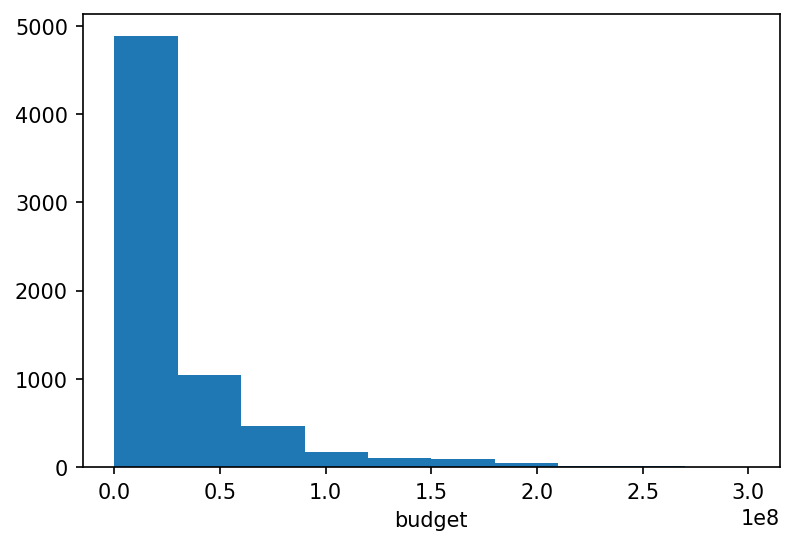

Removing Columns with Zero Values


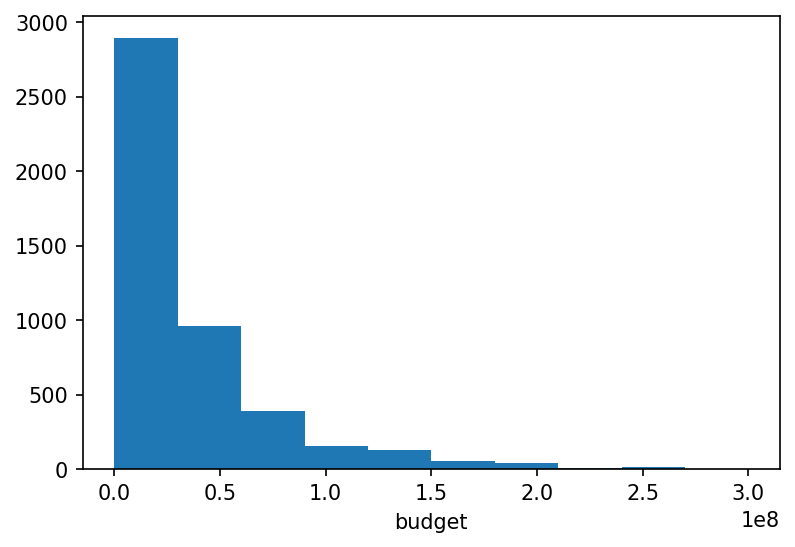

In [9]:
## visualize distribution of the budgets
## how many 0 values are there?
pu.plot_histogram(movies_table.get_column('budget'), 'budget')
print('Removing Columns with Zero Values')
movies_table.remove_rows_with_0_values(column = 'budget')
pu.plot_histogram(movies_table.get_column('budget'), 'budget')

**Figure 1** Distribution of the films' budgets. The data is right skewed both before and after we remove the missing values.

# Create a class label
For the classification task, we would like an equal distribution of classes. We're interested in seeing which movies make a profit, so let's subtract the film's gross from it's budget and see the distribution of the classes (see Figure 2).

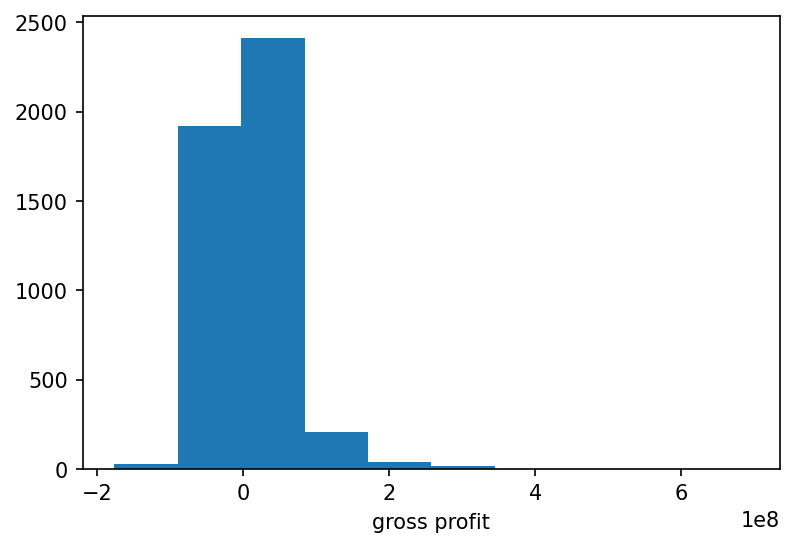

In [10]:
gross_profit = [movies_table.get_column('gross')[i] - movies_table.get_column('budget')[i] for i in range(len(movies_table.data))]
pu.plot_histogram(gross_profit, 'gross profit')

**Figure 2** Distribution of the film's gross profit.

## Histogram Analysis 
- Less than 100 movies lost 200,000,000 
- Less than 2,000 movies broke even 
- Less than 500 movies made a profit of 100,000,000
- Less than 100 movies made a profit of 200,000,000


In Figure 2, we can see that roughly half of the film's break even (and are on the positive side of the histogram) and roughly half of them are lose money (and are on the negative half of the histogram). Therefore, we used a binary flag indicating if the film profited or not as our class label to predict. We then added the resulting column to our dataset.

In [11]:
profitted = [0 if gross < 0 else 1 for gross in gross_profit]
movies_table.add_column(profitted, 'profitted')

### Which features are associated with higher grossing movies?
We now need to decide which feature to input into our classifiers. To do so, we will check if any genres are associated with higher grossing movies first.

Movies that did not make a profit


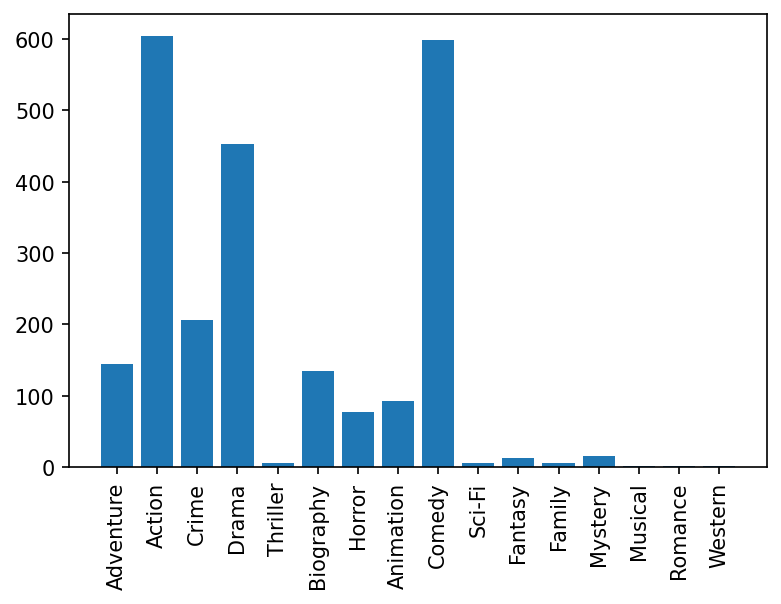

Movies that did make a profit


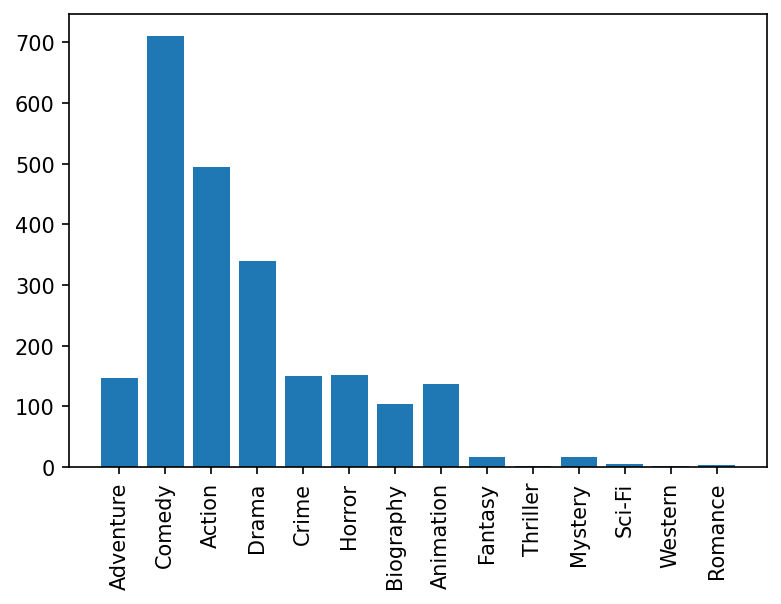

In [12]:
profit_groups = movies_table.group_by('profitted')
genre_idx = movies_table.column_names.index('genre')
for i in range(2):
    if i == 0:
        print("Movies that did not make a profit")
    else:
        print("Movies that did make a profit")
    genre_cnt = Counter([x[genre_idx] for x in profit_groups[1][i]])
    pu.plot_bar_chart(labels = genre_cnt.keys(), y = genre_cnt.values())

**Figure 3** The genres associated with movies that broke even and movies that did not.

We can see in figure 3, that comedies are more represented in the group of movies that made a profit.

# Gross Profit
- The grossness of a movie is the total profit minus the budget

# Relationship between features and budget
If we want to predict a film's success, we first need to understand what features most closely correlate with the gross profit of a film. We can use our prior understanding of what makes a film successful (e.g., high audience rating, high audience engagement) to decide what relationships to investigate.

### IMDb rating and gross profit
This graph demonstrates that the higher the rating the more profit that the film is likely to make.  

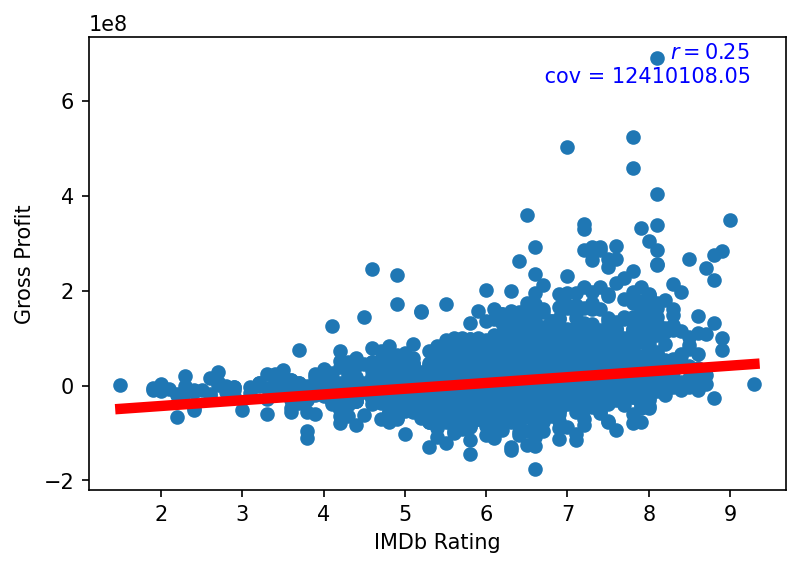

In [13]:
pu.plot_scatterplot(movies_table.get_column('score'), gross_profit, 'IMDb Rating', 'Gross Profit', linear_reg = True, legend_loc = 'upper right')

**Figure 4** The correlation between rating on IMDb and gross profit.

## Number of votes on IMDb and Gross Profit
This graph demonstrates that the number of audience members that choose to rate the film on IMDb has a correlation with the  profit that the film is likely to make. We can expect this since a person must pay for a ticket or rent the movie online before they give it a rating.

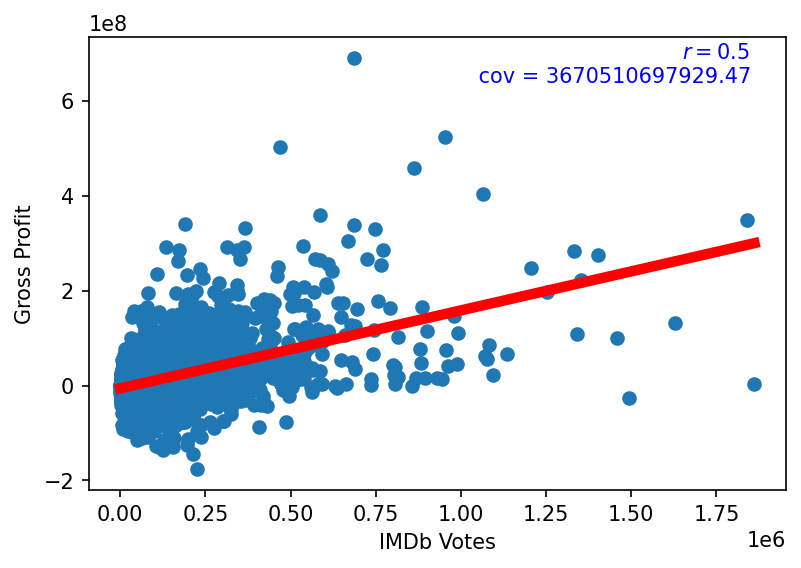

In [14]:
pu.plot_scatterplot(movies_table.get_column('votes'), gross_profit, 'IMDb Votes', 'Gross Profit', linear_reg = True, legend_loc = 'upper right')

**Figure 5** The correlation between the number of votes on IMDb.

One of the strongest correlations that we found was between the number of votes that a movie recieved and its gross profit. This is expected since presumably only people who watched the film would give it a rating on IMDb, and if someone watched the movie, they probably paid to do so.

### Are some ratings associated with lower or higher median profit values?

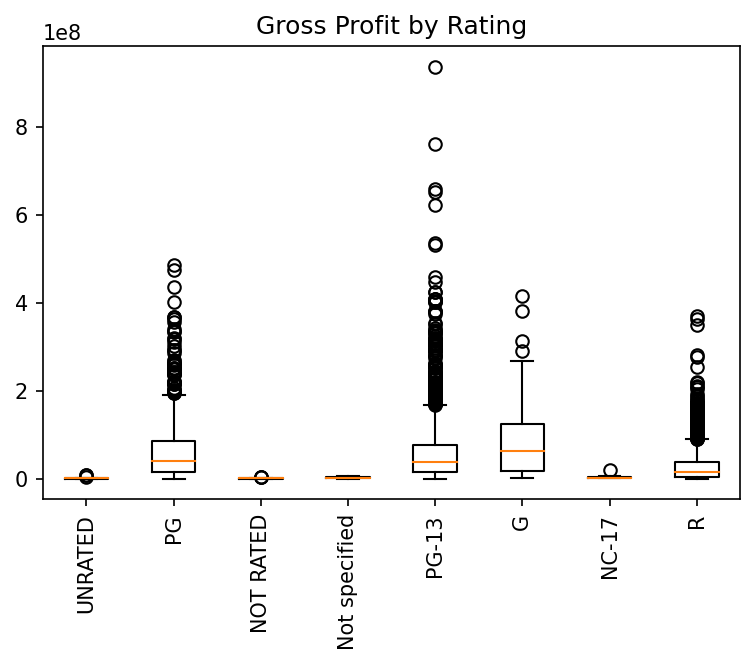

In [15]:
rating_tables = movies_table.group_by("rating")
ratings = {}
for i in range(len(rating_tables[0])):
    rating_name = rating_tables[0][i]
    gross_idx = movies_table.column_names.index("gross")
    ratings[rating_name] = [x[gross_idx] for x in rating_tables[1][i]]
pu.plot_dictionary_boxplot(ratings, "Gross Profit by Rating", rotate_x = True)

**Figure 7** The distribution of gross profit across genres.

Unsurprisingly, movies that appeal to a general audience tend to make more of a profit. G and PG movies had a higher median gross profit then more mature rated films.

# Testing Classifiers on the dataset

We tested 4 different classifiers on the dataset. We evaluated each classifier with stratified K-fold cross validation. We have an equal distribution of class labels, so we wanted to preserve that in our training and test sets. We also used confusion matrices to make sure that there weren't more false positives than false negatives or vice versa.

In [23]:
def test_folds(k, X_train_folds, X_test_folds, classifier, feature_cols, normalize = False, confusion_matrix = False):
    # evaluation metrics for each fold
    all_preds = []
    actuals = []
    for i in range(k):
        # get features and labels
#         feature_cols = ['budget', 'votes', 'genre', 'rating', 'score', 'star', 'director', 'writer']
        features = movies_table.get_key_columns(feature_cols)
        outcomes = profitted
        
        # get the train and test set for linear_regression
        X_train = [features[j] for j in range(len(features)) if j in X_train_folds[i]]
        y_train = [outcomes[j] for j in range(len(outcomes)) if j in X_train_folds[i]]
        X_test = [features[j] for j in range(len(features)) if j in X_test_folds[i]]
        y_test = [outcomes[j] for j in range(len(outcomes)) if j in X_test_folds[i]]
        
        if normalize:
            # normalize the dataset before fitting the kNN model
            scale = MinMaxScale(X_train, feature_cols)
            scale.get_mins_maxs()
            X_train = scale.normalize(X_train)
            X_test = scale.normalize(X_test)

        # fit the linear regression model
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        all_preds.extend(y_pred) # add the predictions
        actuals.extend(y_test) # add the actuals

    if confusion_matrix:
        # print out the confusion matrix for the labels
        labels = list(set(actuals))
        print('Confusion matrix')
        matrix = myeval.confusion_matrix(actuals, all_preds, labels)
        print(myutils_tabulate.format_confusion_matrix(matrix, labels))
       
        
    else:
        # compute accuracy for the train and test sets
        acc = myutils.compute_accuracy(all_preds, actuals)
        error = myutils.compute_accuracy(all_preds, actuals, error_rate = True)

        print('accuracy = {}, error rate = {}'.format(round(acc, 2), 
                                                                         round(error,2)))
       

In [24]:
k = 10
X_train_folds_strat, X_test_folds_strat = myeval.stratified_kfold_cross_validation(movies_table.data, 
                                                                                   profitted, n_splits=k)

## Decision Tree Classification


In [25]:
print('-----------------------------------------------------')
print('Decision Tree - 10-fold Stratified Cross Validation with confusion matrix')
print('-----------------------------------------------------')
dt_class = MyDecisionTreeClassifier()
print('Cross Validation Results')
feature_cols = ['discretized_budget', 'discretized_vote', 'genre', 'rating', 'discretized_score']
test_folds(k, X_train_folds_strat, X_test_folds_strat, dt_class, feature_cols)
print('Confusion Matrix Results')
test_folds(k, X_train_folds_strat, X_test_folds_strat, dt_class, feature_cols, confusion_matrix = True)

-----------------------------------------------------
Decision Tree - 10-fold Stratified Cross Validation with confusion matrix
-----------------------------------------------------
Cross Validation Results
accuracy = 0.62, error rate = 0.38
Confusion Matrix Results
Confusion matrix
          0     1    Total    Recognition (%)
-----  ----  ----  -------  -----------------
0   |  1178  1182     2360            49.9153
1   |   564  1714     2278            75.2414


In [26]:
dt_class.print_decision_rules(feature_cols)

IF discretized_vote == 2 THEN class = 0.
IF discretized_vote == 3 THEN class = 0.
IF discretized_vote == 4 THEN class = 1.
IF discretized_vote == 5 THEN class = 1.


For the tree based classifiers, we opted to use the discretized values of budget, vote, and score. When we used the non-discretized features the decision tree had very low accuracy (<30%). For a similar reason, we excluded the high cardinality features like director, star, and writer.

## Random Forest Classifier


In [27]:
import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MySimpleLinearRegressor, MyNaiveBayesClassifier, MyDecisionTreeClassifier, ZeroRClassifier, RandomClassifier, MyRandomForestClassifier


print('-----------------------------------------------------')
print('Random Forest Classifier  - 10-fold Stratified Cross Validation with confusion matrix')
print('-----------------------------------------------------')
rf_class = MyRandomForestClassifier(N = 6, M = 5, F = 5, seed = 0)
print('Cross Validation Results')
feature_cols = ['discretized_budget', 'discretized_vote', 'genre', 'rating', 'discretized_score']
test_folds(k, X_train_folds_strat, X_test_folds_strat, rf_class, feature_cols)
print('Confusion Matrix Results')
test_folds(k, X_train_folds_strat, X_test_folds_strat, rf_class, feature_cols, confusion_matrix = True)

-----------------------------------------------------
Random Forest Classifier  - 10-fold Stratified Cross Validation with confusion matrix
-----------------------------------------------------
Cross Validation Results
accuracy = 0.62, error rate = 0.38
Confusion Matrix Results
Confusion matrix
          0     1    Total    Recognition (%)
-----  ----  ----  -------  -----------------
0   |  1178  1182     2360            49.9153
1   |   564  1714     2278            75.2414


We then checked if the random forest would outperform just a single decision tree. It oddly did not. We tested several different values of N, M, and F. The highest accuracy score was associated with F - 5. When F = 5, the values of N and M did not improve the accuracy when increased. When F = 5, it's likely that many of the best trees will see all of the available attributes. They then select the attribute with the greatest entropy. In most cases, this will be the discretized vote column. We mentioned previously that the number of votes has a strong correlation with profit simply because people can only vote for the movie if they've seen it. 

## Naive Bayes Classification

In [28]:
print('-----------------------------------------------------')
print('Naive Bayes - 10-fold Stratified Cross Validation with confusion matrix')
print('-----------------------------------------------------')
nb_class = MyNaiveBayesClassifier()
print('Cross Validation Results')
feature_cols = ['discretized_budget', 'discretized_vote', 'genre', 'rating', 'discretized_score', 'star', 'writer', 'director']
test_folds(k, X_train_folds_strat, X_test_folds_strat, nb_class, feature_cols)
print('Confusion Matrix Results')
test_folds(k, X_train_folds_strat, X_test_folds_strat, nb_class, feature_cols, confusion_matrix = True)

-----------------------------------------------------
Naive Bayes - 10-fold Stratified Cross Validation with confusion matrix
-----------------------------------------------------
Cross Validation Results
accuracy = 0.49, error rate = 0.51
Confusion Matrix Results
Confusion matrix
         0     1    Total    Recognition (%)
-----  ---  ----  -------  -----------------
0   |  365  1995     2360            15.4661
1   |  352  1926     2278            84.5478


Naive Bayes performed no better than randomly selecting the dataset, except it did not perform well when predicting which films would not make a profit.

## K Nearest Neighbors Classification


In [30]:
print('-----------------------------------------------------')
print('K Nearest Neighbors - 10-fold Stratified Cross Validation with confusion matrix')
print('-----------------------------------------------------')
knn_class = MyKNeighborsClassifier()
print('Cross Validation Results')
feature_cols = ['budget', 'votes', 'genre', 'rating', 'score', 'star', 'director', 'writer']
test_folds(k, X_train_folds_strat, X_test_folds_strat, knn_class, feature_cols, normalize = True)
print('Confusion Matrix Results')
test_folds(k, X_train_folds_strat, X_test_folds_strat, knn_class, feature_cols, normalize = True, confusion_matrix = True)

-----------------------------------------------------
K Nearest Neighbors - 10-fold Stratified Cross Validation with confusion matrix
-----------------------------------------------------
Cross Validation Results
accuracy = 0.62, error rate = 0.38
Confusion Matrix Results
Confusion matrix
          0     1    Total    Recognition (%)
-----  ----  ----  -------  -----------------
0   |  1521   839     2360            64.4492
1   |   901  1377     2278            60.4478


K nearest neighbors performed well on this dataset! We did not use the discretized features for this classifier since KNN could compute the numerical distance between the budget, votes, and scores. We also normalized the data before running the classifier. However, normalizing the data did not improve the accuracy. We therefore did not normalize the data in our deployed app.

## Random Forest Results
The random forest performs with the same accuracy as the MyDecisionTreeClassifer. This is because when F = 5, it's likely that many of the best trees will see all of the available attributes. They then select the attribute with the greatest entropy. In most cases, this will be the discretized vote column. We mentioned previously that the number of votes has a strong correlation with profit simply because people can only vote for the movie if they've seen it. While other values of N, M, and F were experimented with, when F < 5, the results were worse and when F = 5, the accuracy was 62%.

# Classifier Results

Out of the 4 classifiers, 3 had very similar results. With the data as is, we were unable to achieve higher than 62% accuracy. We deployed KNN because we can see from the confusion matrix that it had the most even class recognition. 

# Deployment URL

App URL: https://movies-app-final-project.herokuapp.com/
Example query URL: https://movies-app-final-project.herokuapp.com/predict?budget=100000&votes=2000&genre=Drama&rating=R&score=7&star=%22Brad%20Pitt%22&director=%22Martin%20Scorcese%22&writer=%22Aaron%20Sorkin%22

# Conclusion 

### Summary of Dataset: 

Our dataset was a single CSV file. It contained information about 6,820 movies, having 220 movies each year from the year 1986 to 2016. This data was scraped from IMDb. It contained 15 attributes and we used the grossness of a movie, the budget, genre, rating, score, votes, star, director and writer. We calculated if the movie had a profit based on the grossness of the movie and the budget. If they had made profit we output a 1 and if they didn't it output a 0. We didn't face many challenges with our dataset other than discretizing our data like turning votes into categorical attributes

### Classification approach we developed: 
We evaluated the performance of 4 classifiers using stratified K-fold cross-validation and confusion matrices. We varied the features inputted to each algorithm according to our knowledge of how the algorithm works. 

### Classifiers performance:

The highest classifier we had perform at 62% and two other classifiers Out of the 4 classifiers, 3 had very similar results. We deployed KNN because it had the most even class recongition. To improve performance we could have attempted to descritize our data even more. 
